#### Detect model from Yu, et al
Implementation of the detection model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

Difference(s) from paper:
- Resized to 224x224 and no filtering applied

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, callbacks

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# specify variables for model
path = 'processed_data/WM-clean224'
result_path = 'results'
#model_path = '../saved_models'

filename = 'WM-clean224'
option = '-detund'
map_column = 'waferMap224'

model_id = 'yudetect'
data_id = '224'
note = '' # -optional

In [6]:
# load train, dev, and test sets
# directly from S3
start = time.time()

train_key = f'{path}/{filename}-train{option}.pkl'
dev_key = f'{path}/{filename}-dev.pkl'
test_key = f'{path}/{filename}-test.pkl'

train = pickle.loads(my_bucket.Object(key=train_key).get()['Body'].read())
dev = pickle.loads(my_bucket.Object(key=dev_key).get()['Body'].read())
test = pickle.loads(my_bucket.Object(key=test_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

print(f"Sanity check: {np.unique(train[map_column][0])}")

Wall time: 60.79 seconds
Train: 47863
Dev: 25942
Test: 25943
Sanity check: [0 1 2]


#### Quick EDA

In [7]:
# baseline accuracy of test set
nones = len(test[test.detectLabels == 0])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Baseline accuracy: 85.24%


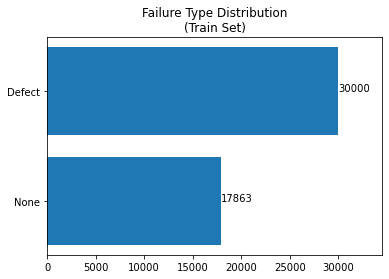

In [8]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set', mode='detect')

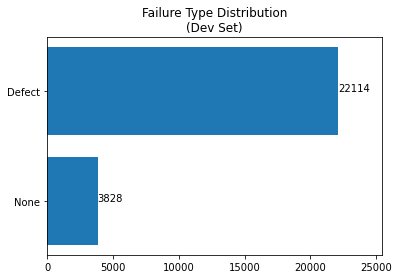

In [9]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set', mode='detect')

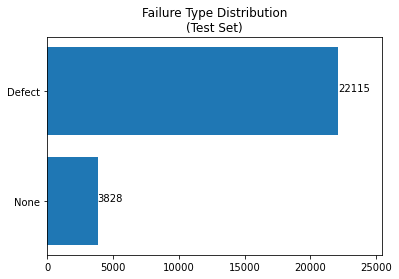

In [10]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set', mode='detect')

#### Data set-up

In [11]:
# prepare inputs
start = time.time()

x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: (#rows, xdim, ydim)
print(x_train.shape)

Wall time: 1.57 seconds
(47863, 224, 224)


In [12]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

Wall time: 5.59 seconds


TensorShape([47863, 224, 224, 1])

In [13]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = np.asarray(train['detectLabels']).astype(np.uint8)
y_val = np.asarray(dev['detectLabels']).astype(np.uint8)
y_test = np.asarray(test['detectLabels']).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
type(y_train[0])

Wall time: 0.00 seconds


numpy.uint8

#### Model

In [14]:
# define model architecture

model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./2., input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

In [15]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [16]:
# run model
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=10)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Epoch 1/10
748/748 [==============================] - 46s 61ms/step - loss: 0.4035 - accuracy: 0.8258 - val_loss: 0.2666 - val_accuracy: 0.9221
Epoch 2/10
748/748 [==============================] - 44s 59ms/step - loss: 0.2320 - accuracy: 0.9106 - val_loss: 0.0972 - val_accuracy: 0.9690
Epoch 3/10
748/748 [==============================] - 44s 59ms/step - loss: 0.1506 - accuracy: 0.9443 - val_loss: 0.1384 - val_accuracy: 0.9498
Epoch 4/10
748/748 [==============================] - 44s 59ms/step - loss: 0.1124 - accuracy: 0.9590 - val_loss: 0.0681 - val_accuracy: 0.9764
Epoch 5/10
748/748 [==============================] - 44s 59ms/step - loss: 0.0931 - accuracy: 0.9652 - val_loss: 0.0603 - val_accuracy: 0.9781
Epoch 6/10
748/748 [==============================] - 44s 59ms/step - loss: 0.0791 - accuracy: 0.9705 - val_loss: 0.0567 - val_accuracy: 0.9803
Epoch 7/10
748/748 [==============================] - 45s 60ms/step - loss: 0.0686 - accuracy: 0.9742 - val_loss: 0.0620 - val_accuracy:

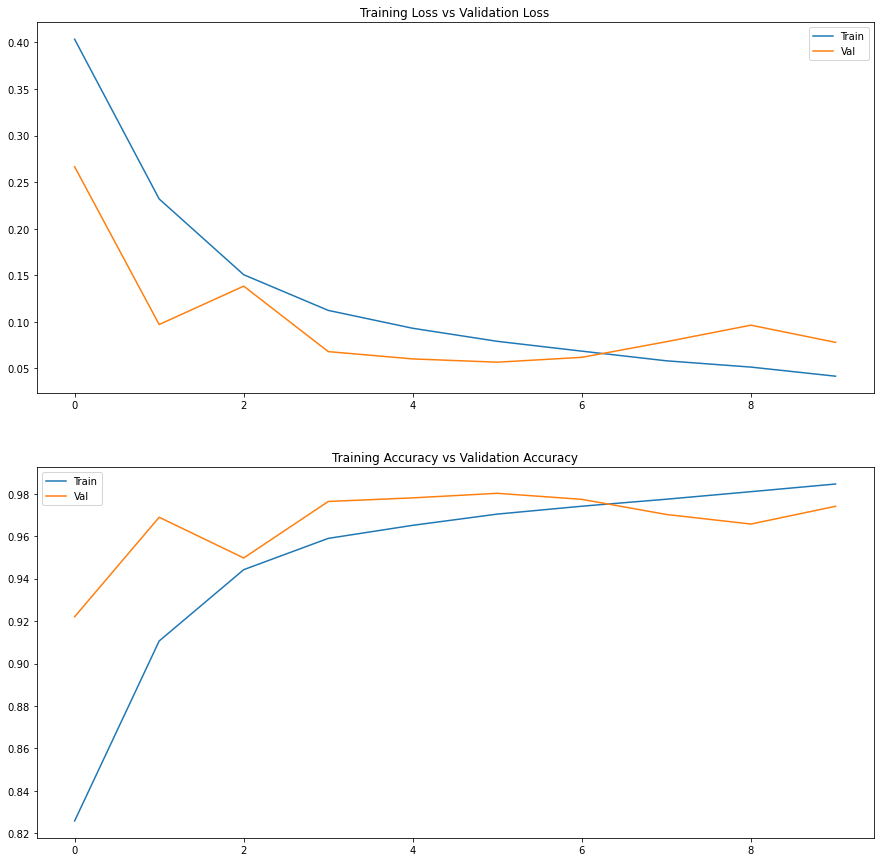

In [17]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [18]:
# # save model to local instance
# model.save(f'{model_path}/{model_id}-{data_id}{note}')

In [19]:
# save model to S3
s3_save_keras_model(model, f'{model_id}-{data_id}{note}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmprss7a257/yudetect-224/assets


In [20]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 8s 10ms/step - loss: 0.0753 - accuracy: 0.9739
Wall time: 8.81 seconds
[0.07533544301986694, 0.9739043116569519]


In [21]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_max = np.argmax(y_pred, axis=1).astype(np.uint8)
predictions = [y_max, y_pred]
print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 6.82 seconds


In [22]:
# save predictions
# save to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

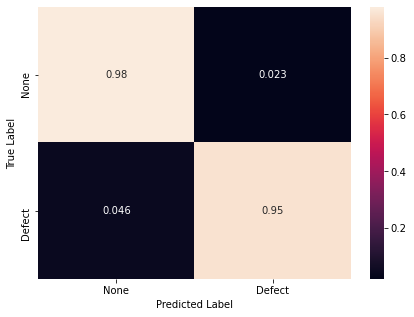

In [23]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_max, mode='detect', normalize=True)

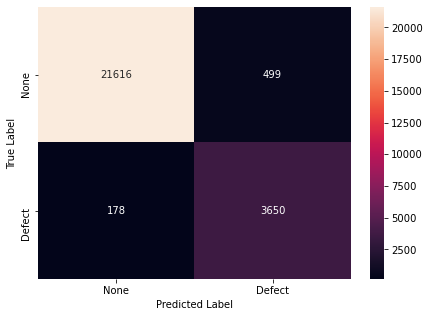

In [24]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_max, mode='detect', normalize=False)